In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from experiments.helpers import plot_all, print_metrics, plot_loss

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Loading and Feature Engineering

In [2]:
df_train = pd.read_csv('./dataset/house_price_train.csv', parse_dates=["Time"])
df_test = pd.read_csv('./dataset/house_price_test.csv', parse_dates=["Time"])

In [3]:
cat_columns = ["City", "District", "Street", "Community", "Floor"] # ["City", "Floor"]
num_columns = ["#Floors", "#Rooms", "#Halls", "Area"]

In [4]:
# drop unused columns
df_train_pool = df_train.drop(columns=["Id", "Time", "Orient", "Lat", "Lon"])
df_test_pool = df_train.drop(columns=["Id", "Time", "Orient", "Lat", "Lon"])

In [5]:
# standardize price
scaler = StandardScaler()
scaler.fit(df_train_pool["Price"].values.reshape(-1, 1))

y_train = scaler.transform(df_train_pool["Price"].values.reshape(-1, 1))
y_test = scaler.transform(df_test_pool["Price"].values.reshape(-1, 1))

In [6]:
X_train_num = df_train_pool[num_columns].values
X_test_num = df_test_pool[num_columns].values

### Deep Learning based model using TensorFlow

In [7]:
# baseline model
tf.random.set_seed(42)

model_inputs = []
models_intermediate = []

# create categorical embedding model
categorical_models = []
for col in cat_columns:
    vocab = list(df_train_pool[col].unique())
    vocab_size = np.minimum(1000, df_train_pool[col].nunique() + 1)
    print(f"{col} vocab size: {vocab_size}")

    cat_input = tf.keras.layers.Input(shape=(1,), name=f"cat_{col}", dtype=tf.string)
    cat_lookup = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, num_oov_indices=0)(cat_input)
    cat_embedding = tf.keras.layers.Embedding(vocab_size, 200)(cat_lookup)
    cat_flatten = tf.keras.layers.Flatten()(cat_embedding)
    
    model_inputs.append(cat_input)
    categorical_models.append(cat_flatten)

# create numerical input
num_normalizer = tf.keras.layers.Normalization()
num_normalizer.adapt(X_train_num)

numerical_input = tf.keras.layers.Input(shape=(4,), name="num_input")
numerical_normalize_layer = num_normalizer(numerical_input)

model_inputs.append(numerical_input)

# merge all inputs
cat_num_concat = tf.keras.layers.concatenate([*categorical_models, numerical_normalize_layer])

# reshape to 3D for RNN
intermediate_reshape_layer = tf.keras.layers.Reshape(target_shape=(1, 4 + len(categorical_models) * 200))(cat_num_concat)

# create LSTM layer
lstm1_layer = tf.keras.layers.LSTM(64, return_sequences=True)(intermediate_reshape_layer)
lstm2_layer = tf.keras.layers.LSTM(64)(lstm1_layer)

# create output layer
output_layer = tf.keras.layers.Dense(1)(lstm2_layer)

# create final model
baseline_model = tf.keras.Model(inputs=model_inputs, outputs=output_layer)

City vocab size: 35


2022-11-03 16:29:53.319947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-03 16:29:53.408259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-03 16:29:53.408542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-03 16:29:53.411218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

District vocab size: 314
Street vocab size: 1000
Community vocab size: 1000
Floor vocab size: 8


2022-11-03 16:29:55.819295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

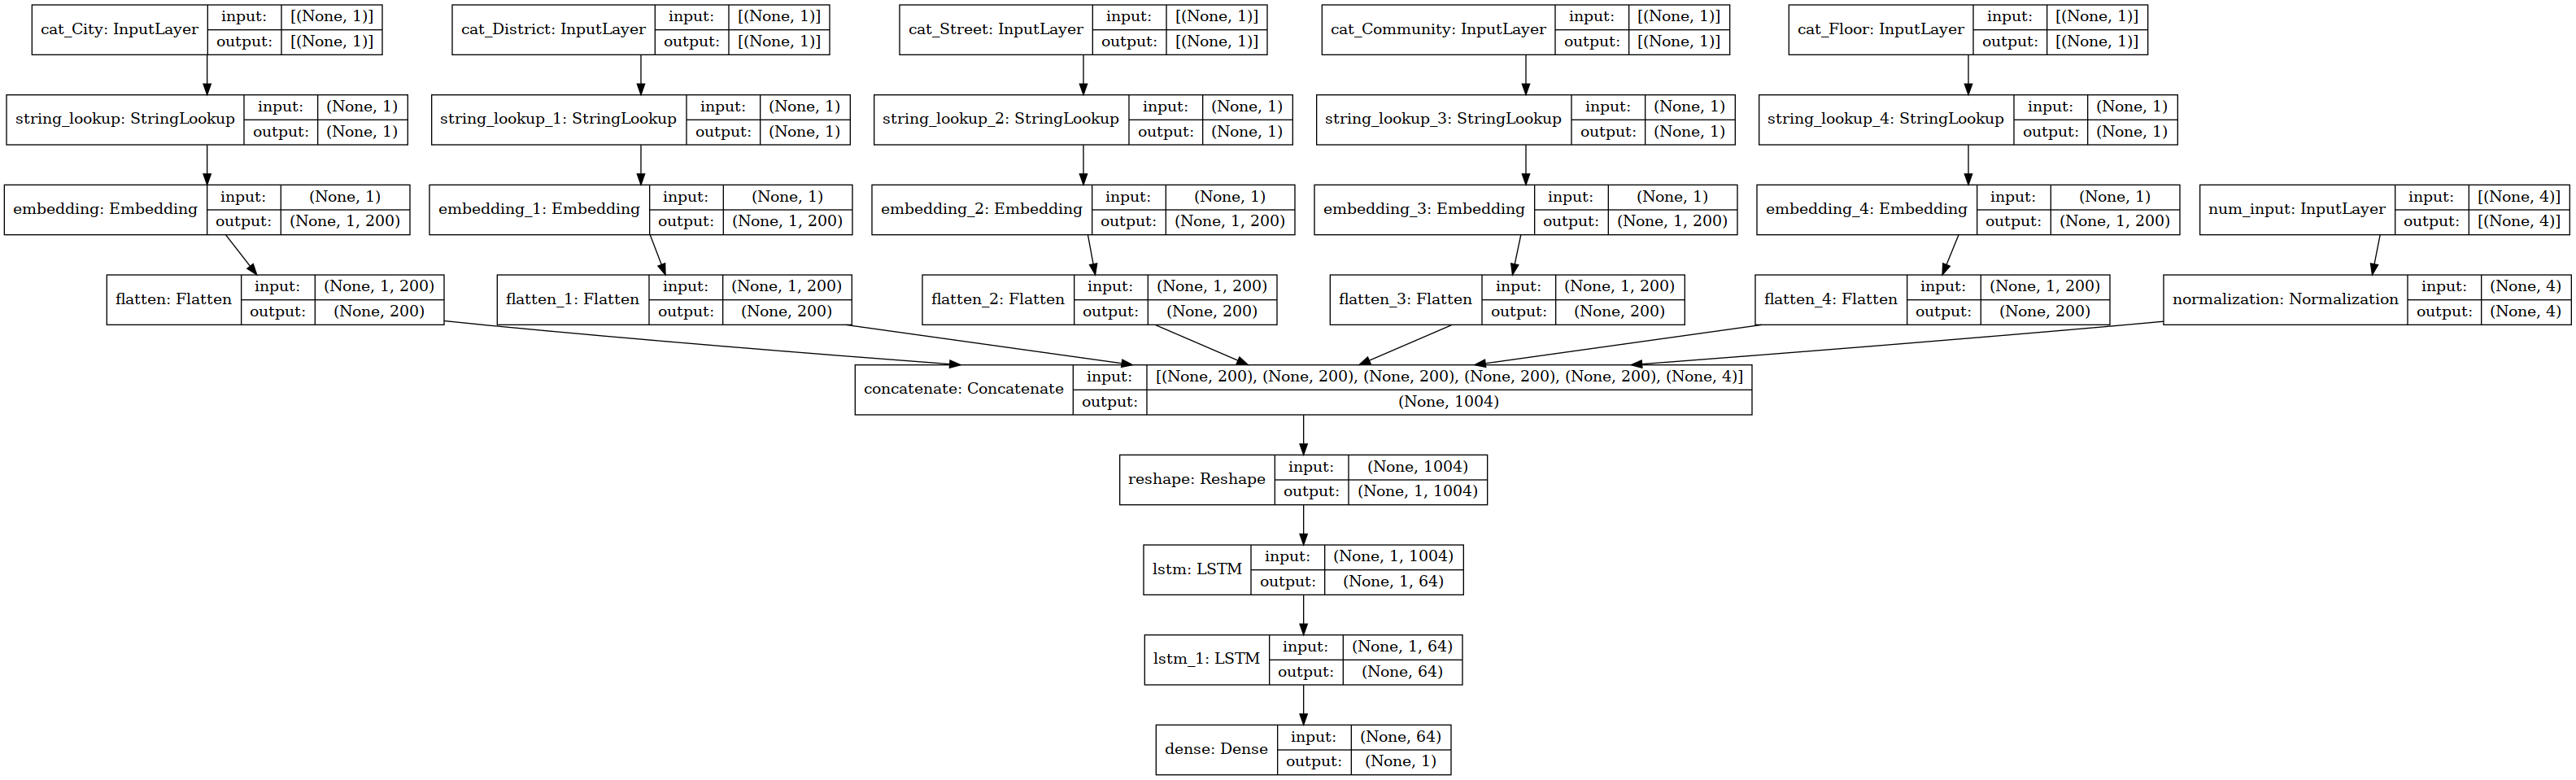

In [9]:
tf.keras.utils.plot_model(baseline_model, show_shapes=True)

In [10]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_City (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_District (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_Street (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_Community (InputLayer)      [(None, 1)]          0                                            
______________________________________________________________________________________________

In [11]:
log_dir = "logs/fit/baseline_lstm_akhir"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

train_inputs = {"num_input": X_train_num}
for col in cat_columns:
    train_inputs[f"cat_{col}"] = df_train_pool[col].values.reshape(-1, 1)

history = baseline_model.fit(train_inputs, y_train, validation_split=0.15, epochs=20, callbacks=[tensorboard_callback])

2022-11-03 16:30:14.594767: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-03 16:30:14.594815: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-03 16:30:14.595902: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-11-03 16:30:14.596206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-11-03 16:30:14.625245: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-11-03 16:30:14.625348: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/20


2022-11-03 16:30:20.610880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401
2022-11-03 16:30:20.862595: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


    4/14692 [..............................] - ETA: 20:05 - loss: 0.7641 - mean_absolute_error: 0.6962

2022-11-03 16:30:21.209069: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-03 16:30:21.209113: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-03 16:30:21.214438: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-11-03 16:30:21.267706: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-03 16:30:21.272422: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-11-03 16:30:21.273981: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-03 16:30:21.280199: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/baseline_lstm_akhir/train/plugins/profile

14692/14692 [==============================] - 585s 39ms/step - loss: 0.3004 - mean_absolute_error: 0.2675 - val_loss: 0.3042 - val_mean_absolute_error: 0.4092
Epoch 2/20
14692/14692 [==============================] - 569s 39ms/step - loss: 0.2837 - mean_absolute_error: 0.2547 - val_loss: 0.2951 - val_mean_absolute_error: 0.4028
Epoch 3/20
14692/14692 [==============================] - 567s 39ms/step - loss: 0.2791 - mean_absolute_error: 0.2509 - val_loss: 0.2804 - val_mean_absolute_error: 0.3957
Epoch 4/20
14692/14692 [==============================] - 601s 41ms/step - loss: 0.2742 - mean_absolute_error: 0.2483 - val_loss: 0.3086 - val_mean_absolute_error: 0.4086
Epoch 5/20
14692/14692 [==============================] - 608s 41ms/step - loss: 0.2707 - mean_absolute_error: 0.2468 - val_loss: 0.2823 - val_mean_absolute_error: 0.3937
Epoch 6/20
14692/14692 [==============================] - 606s 41ms/step - loss: 0.2672 - mean_absolute_error: 0.2452 - val_loss: 0.3142 - val_mean_absolute

In [16]:
baseline_model.save("models/lstm.h5")

## Evaluation

In [12]:
test_inputs = {"num_input": X_test_num}
for col in cat_columns:
    test_inputs[f"cat_{col}"] = df_test_pool[col].values.reshape(-1, 1)

predicted = baseline_model.predict(test_inputs)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  -26337.188
Max:  916137.56
R2:  0.7896853765926926
MAPE:  0.22148265357157032
Log MAE:  nan


/home/fahmi/lomba/ieee-cyberc/experiments/helpers.py:10: RuntimeWarning: invalid value encountered in log
  return np.mean(np.abs(np.log(y_true) - np.log(y_pred)))


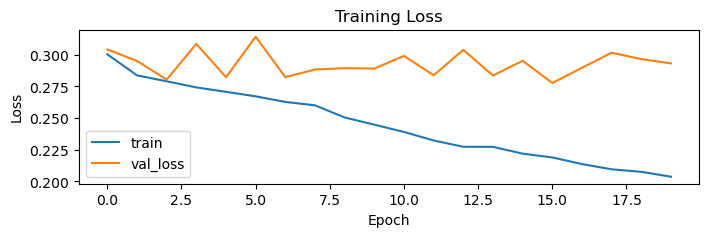

In [13]:
plot_loss(history)
plt.show()

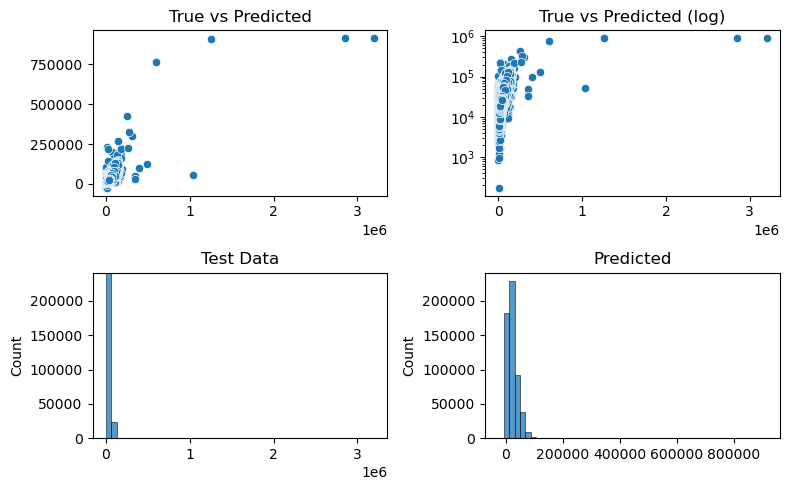

In [14]:
plot_all(y_true_unscaled, predicted_unscaled)
plt.show()